In [1]:
!pip install tensorflow opencv-python-headless

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np
import cv2
import zipfile
import os

# Path to the ZIP file
extracted_folder_path = './newarchive'

# Paths to the extracted train and test directories
train_dataset_path = os.path.join(extracted_folder_path, 'train')
test_dataset_path = os.path.join(extracted_folder_path, 'test')

image_size = (48, 48)
batch_size = 32

# Data augmentation and rescaling
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Load training data
train_generator = datagen.flow_from_directory(
    train_dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Load validation data
validation_generator = datagen.flow_from_directory(
    train_dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

Found 19341 images belonging to 5 classes.
Found 4835 images belonging to 5 classes.


/Users/sina/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [3]:

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Train the model
# model.fit(train_generator, validation_data=validation_generator, epochs=15)

# # Save the model
# model.save('emotion_model.h5')

Found 6043 images belonging to 5 classes.
 22/189 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5295 - loss: 1.2520

/Users/sina/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6331 - loss: 1.1096
Test Loss: 1.1315522193908691
Test Accuracy: 0.6364388465881348
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
                         Filename Predicted   True
0  angry/PrivateTest_10131363.jpg     happy  angry
1  angry/PrivateTest_10304478.jpg     angry  angry
2   angry/PrivateTest_1054527.jpg       sad  angry
3  angry/PrivateTest_10590091.jpg     happy  angry
4   angry/PrivateTest_1109992.jpg     angry  angry


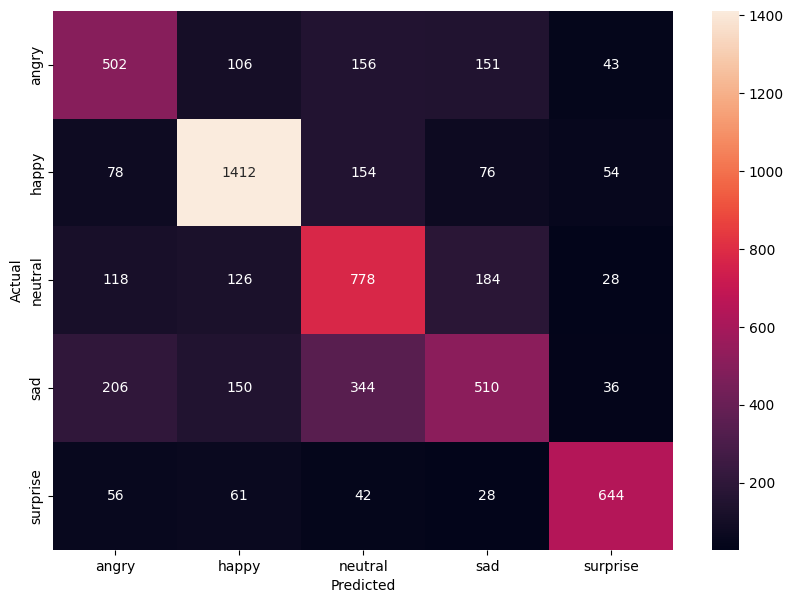

              precision    recall  f1-score   support

       angry       0.52      0.52      0.52       958
       happy       0.76      0.80      0.78      1774
     neutral       0.53      0.63      0.57      1234
         sad       0.54      0.41      0.46      1246
    surprise       0.80      0.77      0.79       831

    accuracy                           0.64      6043
   macro avg       0.63      0.63      0.63      6043
weighted avg       0.63      0.64      0.63      6043



In [4]:
from tensorflow.keras.models import Sequential, load_model
# Load the trained model
model = load_model('emotion_model.h5')

# Data generator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Load test data
test_generator = test_datagen.flow_from_directory(
    test_dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Function to preprocess image for prediction
def preprocess_image(image):
    image = cv2.resize(image, (48, 48))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype('float32') / 255
    image = np.expand_dims(image, axis=0)
    return image

# Predict emotion from image
def predict_emotion(image):
    preprocessed_image = preprocess_image(image)
    prediction = model.predict(preprocessed_image)
    return class_labels[np.argmax(prediction)]

# Load class labels
class_labels = list(test_generator.class_indices.keys())

# Predict emotions for all images in the test set
def predict_test_set(test_generator):
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())
    return predicted_classes, true_classes, class_labels

# Get predictions
predicted_classes, true_classes, class_labels = predict_test_set(test_generator)

# Print some results
import pandas as pd
results_df = pd.DataFrame({
    'Filename': test_generator.filenames,
    'Predicted': [class_labels[i] for i in predicted_classes],
    'True': [class_labels[i] for i in true_classes]
})

# Display some prediction results
print(results_df.head())

# Calculate and print confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

In [5]:
# Load emoji images
emoji_images = {}
for label in class_labels:
    emoji_images[label] = cv2.imread(os.path.join("./emoji", f'{label}.png'), cv2.IMREAD_UNCHANGED)

def overlay_emoji(image, emoji, position=(0, 0), size=(48, 48)):
    image = cv2.resize(image, (200, 200))
    (x, y) = position
    emoji = cv2.resize(emoji, size, interpolation=cv2.INTER_AREA)
    (h, w) = emoji.shape[0], emoji.shape[1]
    alpha_s = emoji[:, :, 3] / 255.0
    alpha_l = 1.0 - alpha_s

    # Ensure the emoji is within the image boundaries
    if x < 0:
        x = 0
    if y < 0:
        y = 0
    if x + w > image.shape[1]:
        w = image.shape[1] - x
        emoji = emoji[:, :w]
        alpha_s = alpha_s[:, :w]
        alpha_l = alpha_l[:, :w]
    if y + h > image.shape[0]:
        h = image.shape[0] - y
        emoji = emoji[:h, :]
        alpha_s = alpha_s[:h, :]
        alpha_l = alpha_l[:h, :]

    for c in range(0, 3):
        image[y:y+h, x:x+w, c] = (alpha_s * emoji[:, :, c] + alpha_l * image[y:y+h, x:x+w, c])
    return image


# Predict emotion from image and overlay emoji
def predict_and_overlay(image_path, model, class_labels, emoji_images):
    image = cv2.imread(image_path)
    preprocessed_image = preprocess_image(image)
    prediction = model.predict(preprocessed_image)
    predicted_label = class_labels[np.argmax(prediction)]
    emoji = emoji_images[predicted_label]
    face_coords = detect_face(image)
    if face_coords is not None:
        draw_face_square(image, face_coords)
        (x, y, w, h) = face_coords
        emoji_position = (x, y - w)  # Adjust position to be above the face
        image = overlay_emoji(image, emoji, position=emoji_position)
        image = put_text_on_image(image, predicted_label, position=(image.shape[1] - 10, 10))
    return image, predicted_label

def put_text_on_image(image, text, position, font=cv2.FONT_HERSHEY_SIMPLEX, font_scale=0.6, color=(255, 255, 255), thickness=2):
    text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]
    text_x = position[0] - text_size[0]
    text_y = position[1] + text_size[1]
    cv2.putText(image, text, (text_x, text_y), font, font_scale, color, thickness)
    return image


def draw_face_square(image, face_coords, color=(0, 255, 0), thickness=2):
    (x, y, w, h) = face_coords
    cv2.rectangle(image, (x, y), (x + w, y + h), color, thickness)
    return image

def detect_face(image):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) > 0:
        return faces[0]  # Return the first detected face
    return None

test_images=['./newarchive/test/neutral/PrivateTest_26814656.jpg',
             './newarchive/test/happy/PrivateTest_218533.jpg',
             './newarchive/test/neutral/PublicTest_99688200.jpg',
             './newarchive/test/angry/PrivateTest_4690573.jpg',
            ]
for image_path in test_images:
    emoji_image, predicted_label = predict_and_overlay(image_path, model, class_labels, emoji_images)
    cv2.imshow(f'Predicted: {predicted_label}', emoji_image)
    cv2.waitKey(0)  # Press any key to move to the next image
    cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
